In [50]:
# Import the main libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Data preprocessing

In [52]:
df = pd.read_csv('fakeNews.csv', delimiter = ';')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3568 entries, 0 to 3567
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Class   3568 non-null   object
 1   Text    3568 non-null   object
dtypes: object(2)
memory usage: 55.9+ KB


In [53]:
df.head(10)

,Class,Text
0,VERDADERO,Algunas de las voces extremistas más conocidas...
1,VERDADERO,Después de casi dos años y medio de luchas pol...
2,VERDADERO,Dos periodistas birmanos de la agencia Reuters...
3,VERDADERO,El Cuerpo Nacional de Policía ha detenido a cu...
4,VERDADERO,El desfile de la firma en Roma se convierte en...
5,VERDADERO,El miedo a la pérdida de identidad y la aversi...
6,VERDADERO,El Ministerio de Exteriores de Rusia ha convoc...
7,VERDADERO,El nuevo plan migratorio del presidente parece...
8,VERDADERO,"El secretario general de Podemos , Lander Mart..."
9,FALSO,El suceso ha tenido lugar en Brasil. Un adoles...


#### Let's take care of the target column and transform it into 0 for FALSO and 1 for VERDADERO

In [55]:
for i in range(len(df['Class'])):
    if df['Class'][i] == 'VERDADERO':
        df['Class'][i] = 1
    else:
        df['Class'][i] = 0

In [56]:
df.head(10)

,Class,Text
0,1,Algunas de las voces extremistas más conocidas...
1,1,Después de casi dos años y medio de luchas pol...
2,1,Dos periodistas birmanos de la agencia Reuters...
3,1,El Cuerpo Nacional de Policía ha detenido a cu...
4,1,El desfile de la firma en Roma se convierte en...
5,1,El miedo a la pérdida de identidad y la aversi...
6,1,El Ministerio de Exteriores de Rusia ha convoc...
7,1,El nuevo plan migratorio del presidente parece...
8,1,"El secretario general de Podemos , Lander Mart..."
9,0,El suceso ha tenido lugar en Brasil. Un adoles...


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3568 entries, 0 to 3567
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Class   3568 non-null   object
 1   Text    3568 non-null   object
dtypes: object(2)
memory usage: 55.9+ KB


#### The target column is still in object format, so we need to take care of it

In [59]:
df['Class'] = df['Class'].astype(int)

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3568 entries, 0 to 3567
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Class   3568 non-null   int32 
 1   Text    3568 non-null   object
dtypes: int32(1), object(1)
memory usage: 41.9+ KB


#### Check if there are null values

In [62]:
df.isnull().sum()

Class    0
Text     0
dtype: int64

#### When training these type of models, it is important to avoid patterns in the order of the dataset (e.g., all fake news samples are grouped together, followed by real news samples, which is our case). If the data is no shuffled, the model might learn spurious correlations based on the order rather than the actual features, leading to bias in the predictions.

#### Shuffling the datasets ensures that the data points are randomly distributed, making the model learn general patterns instead of being influenced by their order. So let's shuffle the dataset to avoid this bias:

In [64]:
df = df.sample(frac = 1)   # We shuffle the dataset sampling 100% (frac = 1) of the rows in random order
df.reset_index(inplace = True)   # Reseting the indexes 
df = df.drop('index', axis = 1)

In [65]:
df.head(10)

,Class,Text
0,1,Se reporta accidente de tránsito en el sur de ...
1,1,El Ayuntamiento de Alcalá de Henares ha enviad...
2,0,Donald Trump construirá un muro alrededor de c...
3,1,Cuando dos nuevas boutiques de moda de lujo ab...
4,1,El Parlamento de Vitoria ha instado este jueve...
5,0,Margarita Zavala busca a Meryl Streep para que...
6,1,"El 48,8% de los catalanes con derecho a voto r..."
7,1,Agentes de la Guardia Civil y de la Policía Lo...
8,1,La producción de castaña ha caído un 25 % en G...
9,0,“Dueños de nuestros silencios y esclavos de nu...


#### Let' see if we have a balance dataset

In [67]:
news = df['Class'].value_counts() # Naming the different diseases and counting how many times they appear in the column

news_data = pd.DataFrame({'Fake News': news.index,
                         'Counts': news.values}) # Store the information of the diseases into a DataFrame for a clearer view
print(news_data) 

   Fake News  Counts
0          1    1829
1          0    1739


Text(0.5, 0, 'Fake News')

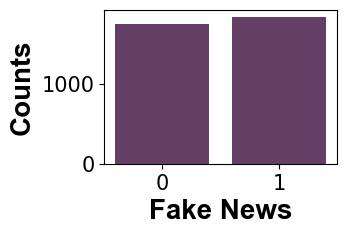

In [68]:
# Plotting the values in a bar plot for clearer understanding
plt.figure(figsize=(3, 2))
plt.bar(news_data['Fake News'], news_data['Counts'], color = '#653e66')
csfont = {'fontname':'Arial'}
plt.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Counts', fontsize = 20, fontweight='bold', **csfont)
plt.xlabel('Fake News', fontsize = 20, fontweight='bold', **csfont)

#### We can see that our dataset is balanced

#### Now it is time to prepare the data for the model, since we have full sentences. We will remove all the stopwords, punctuations and any irrelevant spaces from the text. For that, we will use NLTK Library. Let's import the main modules:

In [70]:
from tqdm import tqdm
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Let's create a function designed to clean and preprocess text data. It will remove unnecesary characters (like punctuation), convert text to lowercase, and remove common English stopwords (like 'and', 'the', 'is', etc.), which do not contribute much to the meaning of the text.

In [72]:
def preprocess_text(text_data):
    stop_words = set(stopwords.words('spanish'))  # Obtén las stopwords en español
    preprocessed_text = []  # Lista para almacenar las frases preprocesadas
    
    for sentence in tqdm(text_data):
        # Elimina signos de puntuación y convierte a minúsculas
        sentence = re.sub(r'[^\w\s]', '', sentence.lower())  
        
        # Filtra las stopwords y mantén solo palabras significativas
        sentence_tokens = [token for token in sentence.split() if token not in stop_words]
        
        # Añade la frase procesada a la lista final
        preprocessed_text.append(' '.join(sentence_tokens))
    
    return preprocessed_text

In [73]:
preprocessed_review = preprocess_text(df['Text'].values)
df['Text'] = preprocessed_review

100%|████████████████████████████████████████████████████████████████████████████| 3568/3568 [00:00<00:00, 8456.97it/s]


## Exploratory Data Analysis

#### Now we can visualize the most repeated words in a wordcloud. Let's make one for the fake news and other for the real news

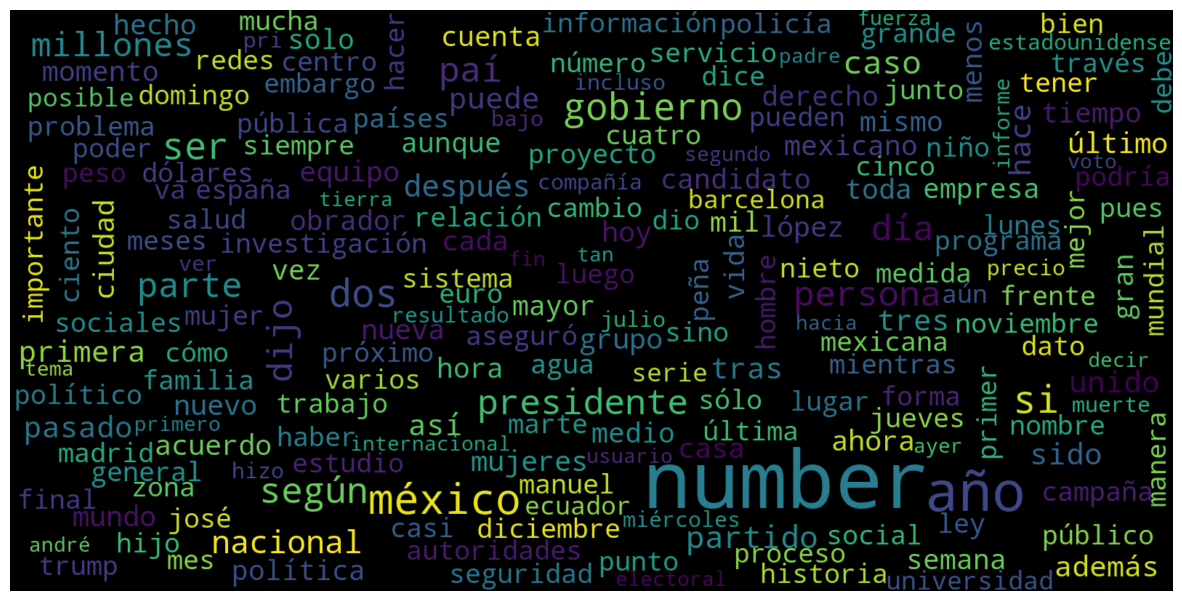

In [75]:
from wordcloud import WordCloud

# Wordcloud for the real news
consolidated = ' '.join(
    word for word in df['Text'][df['Class'] == 1].astype(str))
wordCloud = WordCloud(width = 1600, height = 800, random_state = 21, max_font_size = 110, collocations = False)

plt.figure(figsize = (15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation = 'bilinear')
plt.axis('off')
plt.show()

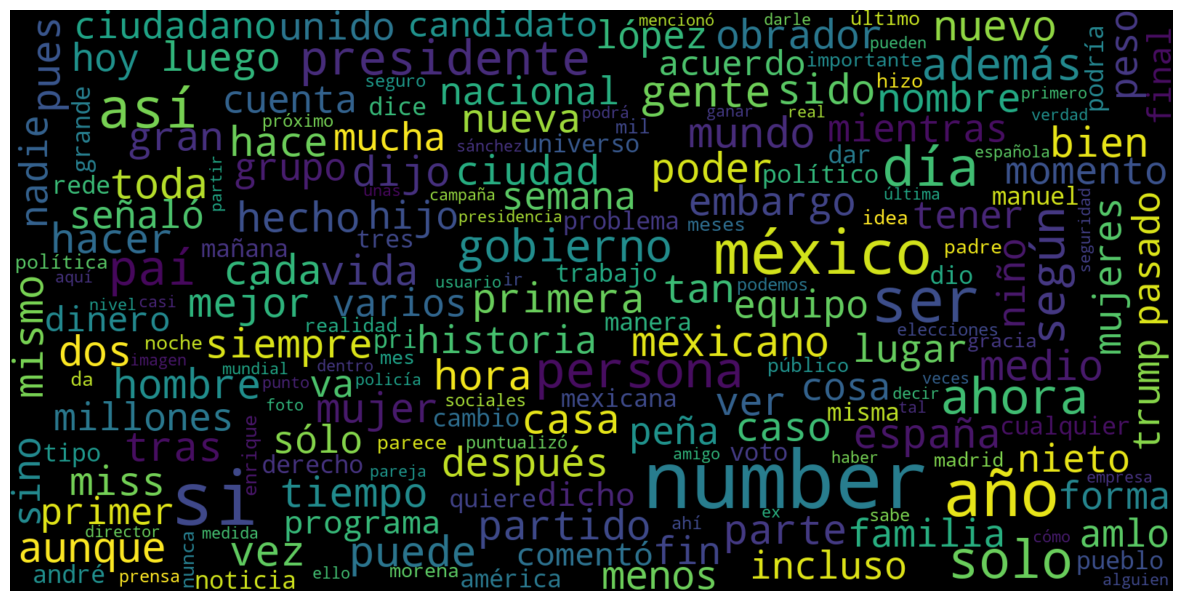

In [76]:
# Wordcloud for the fake news
consolidated = ' '.join(
    word for word in df['Text'][df['Class'] == 0].astype(str))
wordCloud = WordCloud(width = 1600, height = 800, random_state = 21, max_font_size = 110, collocations = False)

plt.figure(figsize = (15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation = 'bilinear')
plt.axis('off')
plt.show()

#### Even though wordclouds are a good start to see the most repeated words, we are going to make a bargraph of the top 20 most repeated words in the dataset:

In [78]:
from collections import Counter

word_list = [word for sentence in preprocessed_review for word in sentence.split()]     # Flatten the list of sentences into a single list of words
word_counts = Counter(word_list)   # Count word frequencies
most_common_words = word_counts.most_common(20)   # Get the most common words
words, counts = zip(*most_common_words)    # Separate words and their frequencies

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, 'number'),
  Text(1, 0, 'si'),
  Text(2, 0, 'años'),
  Text(3, 0, 'méxico'),
  Text(4, 0, 'ser'),
  Text(5, 0, 'dos'),
  Text(6, 0, 'país'),
  Text(7, 0, 'según'),
  Text(8, 0, 'presidente'),
  Text(9, 0, 'gobierno'),
  Text(10, 0, 'así'),
  Text(11, 0, 'dijo'),
  Text(12, 0, 'año'),
  Text(13, 0, 'ahora'),
  Text(14, 0, 'parte'),
  Text(15, 0, 'solo'),
  Text(16, 0, 'personas'),
  Text(17, 0, 'además'),
  Text(18, 0, 'tras'),
  Text(19, 0, 'millones')])

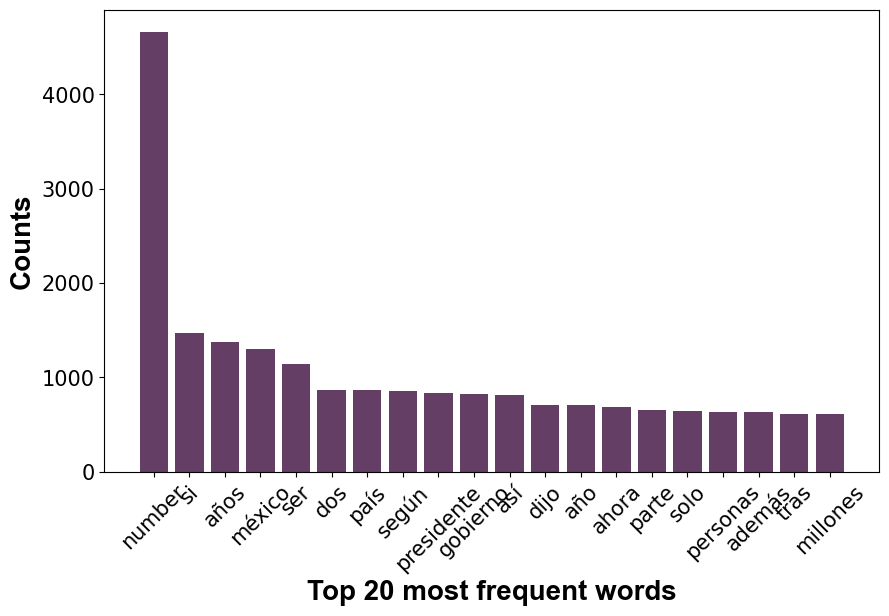

In [79]:
plt.figure(figsize = (10, 6))
plt.bar(words, counts, color = '#653e66')
csfont = {'fontname':'Arial'}
plt.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Counts', fontsize = 20, fontweight='bold', **csfont)
plt.xlabel('Words', fontsize = 20, fontweight='bold', **csfont)
plt.xlabel('Top 20 most frequent words', fontsize = 20, fontweight='bold', **csfont)
plt.xticks(rotation = 45)

## Train/test split and converting text into vectors

In [81]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['Class'], test_size = 0.2, random_state = 19)

In [82]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorization = TfidfVectorizer()
X_train = vectorization.fit_transform(X_train)
X_test = vectorization.transform(X_test)

## Model training

In [85]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(X_train, y_train)

LogisticRegression()

Accuracy Score (Logistic Regression model): 79.97198879551821 %


<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

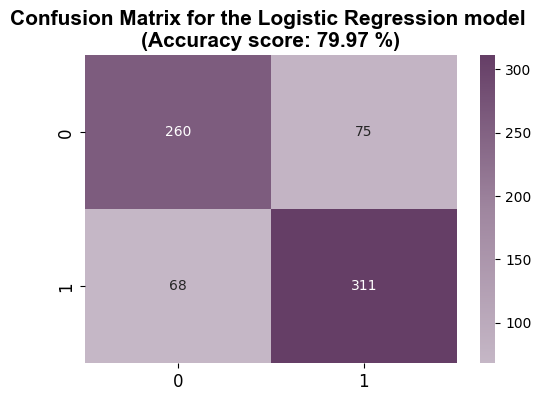

In [86]:
y_pred = classifier.predict(X_test)

from sklearn.metrics import accuracy_score, confusion_matrix

print("Accuracy Score (Logistic Regression model):", accuracy_score(y_test, y_pred)*100, "%") # Print the accuracy score for the predictions

cm = confusion_matrix(y_test, y_pred)  # Generate the confusion matrix

from matplotlib.colors import LinearSegmentedColormap
colors = ["#c5b7c6", "#9f869f", "#653e66"]  # Light purple to dark purple
custom_cmap = LinearSegmentedColormap.from_list("purple_custom", colors) # Custom map for the confusion matrix

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot = True, fmt='d', cmap = custom_cmap)   # Plot the confusion matrix into a heatmap
csfont = {'fontname':'Arial'}
plt.tick_params(axis='both', which='major', labelsize=12)
plt.title(f'Confusion Matrix for the Logistic Regression model \n(Accuracy score: {accuracy_score(y_test, y_pred)*100:.2f} %)', fontsize = 15, fontweight='bold', **csfont)
plt.tight_layout

## Single prediction

#### Let's try to predict if a news is real or fake:

In [132]:
news_text_test = """ 

La Reserva Federal ha bajado los tipos de interés de Estados Unidos por tercera vez desde septiembre, hasta dejarlos en un cuarto de punto menos, es decir, en una franja de entre el 4,25% y el 4,5%. Pero eso no es noticia. De hecho, el mercado de futuros daba un 95% de posibilidades a que el precio del dinero bajara. Así que el movimiento está más que descontado.

La noticia es que el banco central estadounidense no cree que el actual ritmo de reducción de tipos se vaya a mantener en 2025. Eso es lo que se verdad interesaba al mercado, después de unos datos en el último mes y medio que muestran una inflación sorprendentemente resistente y un mercado laboral, que sigue sin conocer lo que es el paro. Sin embargo, y pese a esa expansión, los indicadores económicos muestran menos vigor que a principios de año. Eso deja al instituto emisor en una situación complicada: por una parte, tiene que garantizar el control de los precios; por otra, debe buscar el pleno empleo.

Así, la llamada "línea de puntos" en la que los miembros del Comité del Mercado Abierto de la 'Fed' -que es el organismo del banco central que decide la política monetaria de Estados Unidos- trazan sus perspectivas para el año próximo, solo prevé dos bajadas de tipos de un cuarto de punto cada una. Es la tercera vez consecutiva que el comité reduce las expectativas para el año que viene. La consecuencia es que el precio del dinero apenas se reducirá en los próximos 12 meses. Eso, claro está, si se cumplen las previsiones.

El resultado ha sido un refuerzo inmediato del dólar, que alcanzado sus niveles más altos en dos años, y una caída de la bolsa, que lleva semanas, rompiendo récords.

La economía de la primera potencia mundial experimentó un crecimiento anualizado del 2,8% en el PIB del tercer trimestre de 2024 frente al 3% de los tres meses previos.

En cuanto al mercado laboral estadounidense, se crearon 227.000 empleos no agrícolas durante noviembre, muy por encima de los 36.000 de octubre que se anotaron ante el impacto de los huracanes en el sur del país. Sin embargo, el paro subió una décima al 4,2%.

El índice de precios de gasto de consumo personal, la estadística preferida por la Fed para monitorizar la inflación, se situó en octubre en el 2,3%, dos décimas más. La tasa mensual registró un avance del 0,2%, sin cambios. La variable subyacente cerró en el 2,8% interanual, una décima más.

"""
test_df = pd.DataFrame([[news_text_test]], columns = ['text'])

In [134]:
preprocessed_test = preprocess_text(test_df['text'].values)
test_df['text'] = preprocessed_test

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


In [136]:
X_news_test = vectorization.transform(test_df['text'])

In [138]:
news_prediction = classifier.predict(X_news_test)

In [140]:
if news_prediction == 0:
    print('This is a fake news.')
else:
    print('This is a real news')

This is a real news
